In [1]:
import pandas as pd
import numpy as np
from sklearn.utils.extmath import randomized_svd
from scipy import stats

In [2]:
wine = pd.read_csv('/Users/victor/Documents/DataLab/2018/wine.csv')

In [3]:
wine.head()

,Year,Origin,Group,A,VA,TA,FA,pH,TPR,TPS,...,PC,ACR,ACS,ACC,CI,CI2,H,I,CA,VPC
w1,1986,Ribera,R86,12.8,1.20,6.7,5.2,3.7,2827,50.8,...,3794,386,287,181,7.81,8.95,0.720,18.4,0.489,0.21
w2,1986,Ribera,R86,12.8,0.75,6.9,6.0,3.5,1818,37.8,...,1736,144,141,69,4.88,5.55,0.755,23.6,0.480,0.56
w3,1986,Ribera,R86,12.5,1.00,7.2,6.0,3.6,1459,35.1,...,2306,225,132,78,5.52,6.35,0.456,36.8,0.598,0.38
w4,1986,Ribera,R86,11.9,0.70,7.7,6.8,3.3,2054,32.1,...,3420,204,110,84,4.64,5.15,0.675,36.4,0.420,0.29
w5,1986,Ribera,R86,12.5,0.95,7.7,6.3,3.6,2930,49.6,...,3158,214,148,75,6.99,7.87,0.672,34.2,0.450,0.36


### Standardize

In [4]:
Y_ = wine.iloc[:,:3]
X = wine.iloc[:,3:].as_matrix()
medias = X.mean(axis=0)
desv = X.std(axis=0)
dim = X.shape[1]

In [5]:
X_st = (X-medias)/desv

### Groups

In [6]:
GroupNames = Y_.Group.unique()
g = len(GroupNames)
n = X_st.shape[0]
m = X_st.shape[1]
r = np.min(np.array([g - 1, m]))

In [7]:
def Factor2Binary(y,Name = None):
    if Name == None:
        Name = "C"
    ncat = len(y.unique())
    n = len(y)
    Z = pd.DataFrame(0, index=np.arange(len(y)), columns=y.unique())
    for col in Z.columns:
        for i in range (0,n):
            if y[i] == col:
                Z[col].iloc[i] = 1
    return Z

In [8]:
def matrixsqrt(M,dim,tol=np.finfo(float).eps,inv=True):
    U, Sigma, VT = randomized_svd(M, n_components=dim, n_iter=5, random_state=None)
    nz = Sigma > tol
    if inv==True:
        S12 = U.dot(np.diag(1/np.sqrt(Sigma[nz]))).dot(VT[nz,:])
    else:
        S12 = U.dot(np.diag(np.sqrt(Sigma[nz]))).dot(VT[nz,:])
    return S12

In [9]:
#Groups to Binary
Z = Factor2Binary(Y_.Group)
ng = Z.sum(axis=0)
S11 = (Z.T).dot(Z)
Xb = np.linalg.inv(S11).dot(Z.T).dot(X_st)
B = (Xb.T).dot(S11).dot(Xb)
S = (X_st.T).dot(X_st) - B
Y = np.power(S11,0.5).dot(Xb).dot(matrixsqrt(S,dim,inv=True))

U, Sigma, VT = randomized_svd(Y, n_components=dim, n_iter=5, random_state=None)

#Variable_Coord
H = matrixsqrt(S,dim,inv=False).dot(np.transpose(VT[0:r,:]))
#Canonical_Weights
B = matrixsqrt(S,dim,inv=True).dot(np.transpose(VT[0:r,:]))

#Group_Coord
J = Xb.dot(B)

#Individual_Coord
V = X_st.dot(B)

In [10]:
sct = np.diag((V.T).dot(V))
sce = np.diag((J.T).dot(S11).dot(J))
scr = sct -sce
fs = (sce/(g - 1))/(scr/(n - g))

#eigenvectors
vprop = Sigma[:r]
#Inertia
iner = (np.power(vprop,2)/(np.power(vprop,2).sum()))*100

In [11]:
lamb = np.power(vprop,2)
pill = 1/(1 + lamb)
pillai = np.linalg.det(np.diag(pill))
glh = g - 1
gle = n - g
t = np.sqrt((np.power(glh,2) * np.power(m,2) - 4)/(np.power(m,2) + np.power(glh,2) - 5))
w = gle + glh - 0.5 * (m + glh + 1)
df1 = m * glh
df2 = w * t - 0.5 * (m * glh - 2)

In [12]:
Wilksf = (1 - np.power(pillai,1/t))/(np.power(pillai,1/t)) * (df2/df1)
Wilksp = stats.f.pdf(Wilksf, df1, df2)

### Radius

In [19]:
falfau = stats.t.ppf(1 - (0.025), (n - g))
falfab = stats.t.ppf(1 - (0.025/(g * m)), (n - g))
falfam = np.sqrt(stats.f.ppf(1 - 0.05, m, (n - g - m + 1)) * (((n - g) * m)/(n - g - m + 1)))
falfac = 2.447747

In [20]:
print(falfau,falfab,falfam,falfac)

2.01954096398 3.6691725086 7.94799764446 2.447747


In [21]:
UnivRad = falfau * np.diag(np.linalg.inv(np.sqrt(S11)))/np.sqrt(n - g)
BonfRad = falfab * np.diag(np.linalg.inv(np.sqrt(S11)))/np.sqrt(n - g)
MultRad = falfam * np.diag(np.linalg.inv(np.sqrt(S11)))/np.sqrt(n - g)
ChisRad = falfac * np.diag(np.linalg.inv(np.sqrt(S11)))/np.sqrt(n - g)

In [23]:
%pylab inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [37]:
H

array([[-1.18339541, -1.00743124,  0.15215876],
       [-0.79470947, -0.14119802, -1.42730958],
       [-0.65296634,  1.6284708 , -0.22727583],
       [-0.42684607,  2.02511774,  0.35514337],
       [ 0.70650353, -1.22008952, -0.9376576 ],
       [-1.10766733, -0.45460002,  0.62836401],
       [-1.23124743, -0.8442504 ,  0.6574132 ],
       [-1.00844261, -0.8501789 ,  1.68098735],
       [-1.09531452, -0.48733026,  0.51199586],
       [ 0.12353087, -0.89060057,  1.7954456 ],
       [ 0.25051289, -1.59090217,  1.49979132],
       [ 0.82560103, -0.92342901,  1.28827966],
       [-1.34883173,  0.05422763,  1.05485886],
       [-1.34767098,  0.00330949,  1.09444782],
       [-0.66318148, -0.77793447, -0.30846911],
       [-0.26869989,  2.15434281,  1.10129861],
       [-1.38591425,  0.32401564, -0.68753323],
       [-0.01588675, -0.34370725,  1.79448243]])

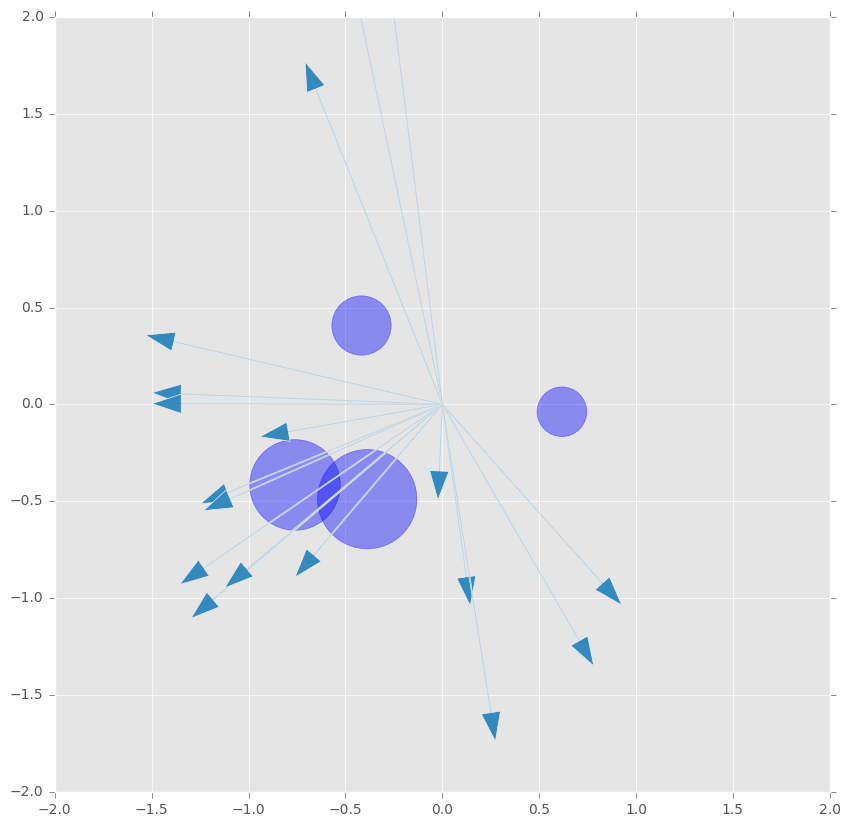

In [48]:
circle1 = plt.Circle(J[0,0:2], BonfRad[0], color='b',alpha=0.4)
circle2 = plt.Circle(J[1,0:2], BonfRad[1], color='b',alpha=0.4)
circle3 = plt.Circle(J[2,0:2], BonfRad[2], color='b',alpha=0.4)
circle4 = plt.Circle(J[3,0:2], BonfRad[3], color='b',alpha=0.4)

fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)


#ax1.scatter(J[:,0],J[:,1])
#ax1.scatter(V[:,0],V[:,1],c='red')
for i in range(0,H.shape[0]):
    ax.arrow(0,0,H[i,0],H[i,1],width=0.005)
#ax.scatter(H[:,0],H[:,1],c='green')